# TP 4 - Perceptron, SVMs

## 1 Implémentation du perceptron
Le fichier source du TP contient un squelette de code pour le perceptron. Il est très proche du TP
précédent sur la descente de gradient.

In [2]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
sns.set(style="white")

In [3]:
class Perceptron:
    def __init__(self,max_iter = 100,eps=1e-3,projection = None):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default

    def fit(self,data,y):
        data = self.projection(data)
        self.w = np.random.random((1,data.shape[1]))
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))
        ylab=set(y.flat)
        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps()*self.loss_g(data[j],y[j:(j+1)])
            self.histo_w[i]=self.w
            self.histo_f[i]=self.loss(data,y).mean(0)
            if i % 100==0: print(i,self.histo_f[i])
            i+=1
    def predict(self,data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    def get_eps(self):
        return self.eps
    def loss(self,data,y):
        return hinge(self.w,data,y)
    def loss_g(self,data,y):
        return grad_hinge(self.w,data,y)

### Q 1.1
Implémenter les fonctions hinge(w,data,y) et grad_hinge(w,data,y) qui calculent le coût
hinge et le gradient du coût pour le vecteur de paramètres w, la matrice d’exemples data et le vecteur
de labels y. Votre code doit fonctionner dans le cas où les différents paramètres sont des vecteurs et
des matrices (utiliser np.reshape pour vous assurez de la nature des paramètres). Transformer de
préférence vos entrées de la manière suivante :
data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1). Penser à utiliser np.sign
et np.maximum.

In [4]:
def f_w(w,x):
    return np.dot(w,x.T)

In [5]:
def hinge(w, data, y, alpha=0):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    return np.maximum(0, alpha - y*f_w(w, data).T)

def grad_hinge(w, data, y):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    return ((-data*y)*(hinge(w, data,y)>0)).mean(0)


### Q 1.2 
Tester sur les données à deux gaussiennes (utiliser la fonction gen_arti()). On prendra $\epsilon$  =
0.001 et on considerera l’apprentissage terminé après 1000 itérations.

(0, array([ 0.]))
(100, array([ 0.]))
(200, array([ 0.]))
(300, array([ 0.]))
(400, array([ 0.]))
(500, array([ 0.]))
(600, array([ 0.]))
(700, array([ 0.]))
(800, array([ 0.]))
(900, array([ 0.]))
('score en train : ', 1.0)
('score en test : ', 1.0)


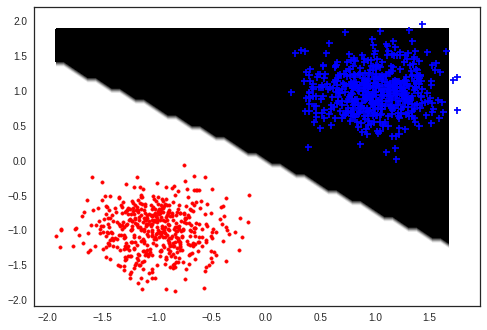

In [7]:
### Test des fonctions hinge, grad_hinge
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
#print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
#print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=0,epsilon=0.001)
xtest,ytest = tools.gen_arti(data_type=0,epsilon=0.001)

plt.ion()

### Apprentissage
model=Perceptron(max_iter=1000,eps=1e-2)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))

#### Tracer de frontiere
plt.figure()
tools.plot_frontiere(xtrain,model.predict,50)
tools.plot_data(xtrain,ytrain)


### Q 1.3
Tracer la trajectoire de l’apprentissage dans l’espace des poids et les frontières obtenues dans
l’espace de représentation des exemples. La solution trouvée est-elle unique ? La frontière de décision
trouvée est-elle pertinente ? Comparer dans le cas où les données sont bruitées (en particulier dans le
cas non linéairement séparable).

In [8]:
### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=0,epsilon=0.5)
xtest,ytest = tools.gen_arti(data_type=0,epsilon=0.5)

plt.ion()

### Apprentissage
model=Perceptron(max_iter=100,eps=1e-2)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))


(0, array([ 0.00026491]))
('score en train : ', 0.98699999999999999)
('score en test : ', 0.99099999999999999)


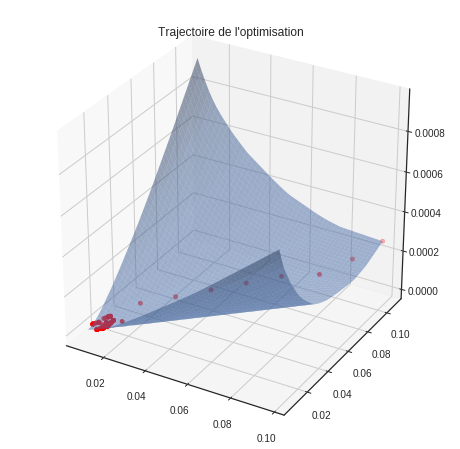

In [9]:
min1,min2 = np.min(model.histo_w,0)
max1,max2 = np.max(model.histo_w,0)
w1 = np.linspace(min1,max1)
w2 = np.linspace(min2,max2)
x,y = np.meshgrid(w1,w2)
grid=np.c_[x.ravel(),y.ravel()]
tab_fonction = np.apply_along_axis(lambda x: hinge(x,xtrain,ytrain).mean(0),1, grid)

fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, tab_fonction.reshape(50,50), alpha=0.5)
ax.scatter(model.histo_w[:,0], model.histo_w[:,1], model.histo_f,c='r')
plt.title("Trajectoire de l'optimisation")


## 2 Données USPS

In [ ]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

In [ ]:
xuspstrain,yuspstrain = load_usps("USPS/USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS/USPS_test.txt")

### Q 2.1
Sur quelques exemples de problèmes 2 classes (6 vs 9, [1,2] vs [6,8] par exemple), entraîner
votre perceptron et visualiser la matrice de poids obtenue

In [ ]:
def plot_pair(n1,n2):
    xtrain, ytrain = get_usps([n1,n2], xuspstrain, yuspstrain)
    xtest, ytest = get_usps([n1,n2], xuspstest, yuspstest)
    m16 = Perceptron(max_iter=100,eps=1e-2)
    m16.fit(xtrain,ytrain)
    print("score en train : ",m16.score(xtrain,ytrain))
    print("score en test : ",m16.score(xtest,ytest))
    show_usps(m16.histo_w[-1,:])
    plt.title('Matrice des poids pour la paire:' +str(n1)+'-'+str(n2))
    

In [ ]:
def score_pair(n1,n2):
    xtrain, ytrain = get_usps([n1,n2], xuspstrain, yuspstrain)
    xtest, ytest = get_usps([n1,n2], xuspstest, yuspstest)
    m16 = Perceptron(max_iter=20,eps=1e-2)
    m16.fit(xtrain,ytrain)
    return m16.score(xtest,ytest)    

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plot_pair(6,9)
plt.subplot(2,2,2)
plot_pair(1,2)
plt.subplot(2,2,3)
plot_pair(6,8)


### Matrice de score

In [ ]:
# Compute the score matrix
corr=np.zeros((10,10))
for i in range(0,10):
    for j in range(0,10):
        if (i != j):
            corr[i,j]=score_pair(i,j)

corr=pd.DataFrame(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=[i for i in range(0,10)], yticklabels=[i for i in range(0,10)],
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)

plt.title('Score entre deux classes pour toutes les pairs en % \n Score = #bien predit / #test')

### Q 2.2 
En utilisant les données de test, tracer les courbes d’erreurs en apprentissage et en test en
fonction du nombre d’itérations. Observez-vous du sur-apprentissage ? Expérimenter dans différents
settings : 1 chiffre contre 1, 1 chiffre contre tous, un sous-ensemble de chiffres contre un autre.## Q 2.2 : 

## 3 Expressivité et feature map

### Q 3.1
Tester votre perceptron sur les autres données artificielles fournies (toujours avec la fonction
gen_arti). Que remarquez vous ? Est-ce normal ?
Afin d’augmenter l’expressivité des classifieurs linéaires, une opération très courante est de plonger
les données dans un espace de dimension supérieure. Soit $\phi : R^d → R^{d'}
$ une fonction de plongement (feature map), l’apprentissage est fait alors sur l’ensemble ${φ(x_n), y_n}$ avec un vecteur de poids w de dimension d'.
La variable projection de la classe Perceptron permet de pré-traiter les données en appliquant une
fonction contenue dans la variable avant tout traitement.

(0, array([ 0.00745832]))
('score en train : ', 0.505)
('score en test : ', 0.503)


UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 18: ordinal not in range(128)

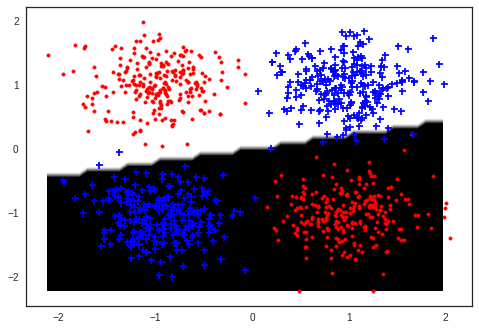

In [14]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
#print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
#print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=1,epsilon=0.2)
xtest,ytest = tools.gen_arti(data_type=1,epsilon=0.2)


### Apprentissage
model=Perceptron(eps=1e-2)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))

plt.figure()
tools.plot_frontiere(xtrain,model.predict,50)
tools.plot_data(xtrain,ytrain)
plt.title('Resultats sur le mélange de deux gaussiennes')

On observe que le classifieur fait très mal son travail car les variables ne sont pas séparables par un hyperplan.

In [ ]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
#print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
#print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=2,epsilon=0.2)
xtest,ytest = tools.gen_arti(data_type=2,epsilon=0.2)


### Apprentissage
model=Perceptron(eps=1e-2)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
plt.figure()
tools.plot_frontiere(xtrain,model.predict,50)
tools.plot_data(xtrain,ytrain)
plt.title('Resultats sur le mélange de deux gaussiennes')

### Q3.2  Plongement polynomiale dans le cas 2D
Soit le plongement (en 2D) polynomiale suivante :$ poly(x) = (1, x_1, x_2, x_1x_2, x_1^2, x_2^2).$ A quoi devraient
correspondre les frontières de décision dans l’espace projeté ? Implémenter et tester.


Les frontières seront des combinaisons linéaires des termes de poly(x), soient des fonctions polynomiales de degré 2.

In [15]:
def poly2D(x):
    res = np.ones((x.shape[0], 6))
    res[:,1] = x[:,0]
    res[:,2] = x[:,1]
    res[:,3] = np.multiply(x[:,0], x[:,1])
    res[:,4] = np.power(x[:,0],2)
    res[:,5] = np.power(x[:,1], 2)
    return res

In [20]:
poly2D(np.array([[1,2]]))

array([[ 1.,  1.,  2.,  2.,  1.,  4.]])

(0, array([ 0.00430179]))
('score en train : ', 0.98999999999999999)
('score en test : ', 0.98999999999999999)


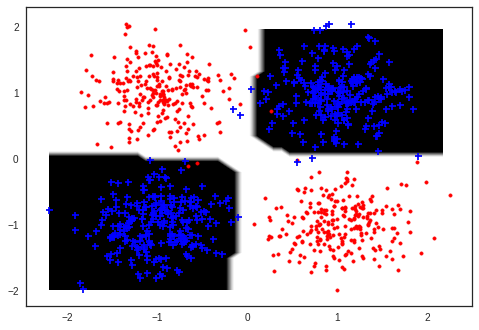

In [22]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=1,epsilon=0.2)
xtest,ytest = tools.gen_arti(data_type=1,epsilon=0.2)


### Apprentissage
model=Perceptron(eps=1e-2, projection = poly2D)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))

##Affichage des frontières
plt.figure()
tools.plot_frontiere(xtrain,model.predict,50)
tools.plot_data(xtrain,ytrain)

On obtient des scores bien meilleures en augmentant l'expréssivité du modèle.

### Q 3.3 Plongement gaussien
Soit $B = (o^i ∈ R^d)_{i=1}^{Nb}$ un ensemble de points dans l’espace de description des exemples. Soit
$gauss_B(x) = (k(x, o^1), k(x, o^2), . . . , k(x, o^{Nb} ))$ avec $k(x, x') = e^{−||x−x'||/2σ^2}$

A quoi correspond la i-ème dimension dans l’espace projeté ? Que signifie une valeur faible ou forte ?
A quoi correspondent dans ce cas les poids $w_i$?
Quelle est la signification d’un poids nul ? d’un poids
positif élevé ? Coder et expérimenter en tirant 

1) aléatoirement des points dans l’espace de description

2) en utilisant un sous-échantillon de l’ensemble d’apprentissage comme base de projection

La i-ème dimension dans l’espace projeté correspond au projeté de X sur un noyau gaussien centré en $o^i$.


In [62]:
Nb = 1000
des = np.random.uniform(-2,2,(Nb, xtrain.shape[1]))
def gaussian_jump(x, descr = des, sigma = 3):
    res = np.zeros((x.shape[0], Nb))
    for i in range(descr.shape[0]):
        res[:,i] = np.exp( - np.linalg.norm(x - descr[i,:],axis=1)/2*(sigma)**2)
    return res

(0, array([ 0.01720446]))
('score en train : ', 0.98199999999999998)
('score en test : ', 0.97399999999999998)


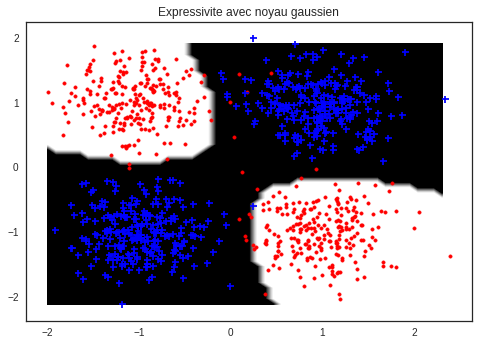

In [63]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=1,epsilon=0.2)
xtest,ytest = tools.gen_arti(data_type=1,epsilon=0.2)


### Apprentissage
model=Perceptron(eps=1e-2, projection = lambda x :gaussian_jump(x,descr = xtrain,sigma = 1))
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
plt.figure()
tools.plot_frontiere(xtrain,model.predict,50)
tools.plot_data(xtrain,ytrain)
plt.title('Expressivite avec noyau gaussien')

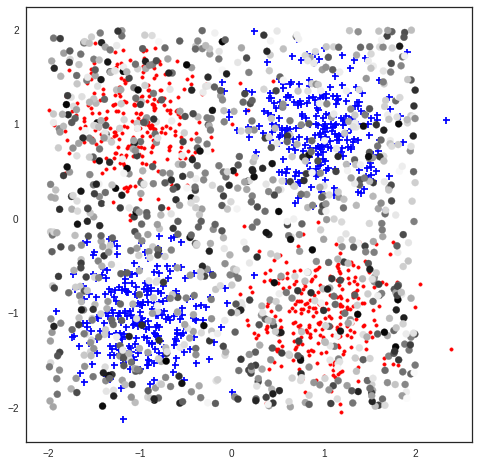

In [65]:
plt.figure(figsize=(8,8))
tools.plot_data(xtrain,ytrain)
plt.scatter(des[:,0],des[:,1],c=model.histo_w[-1,:])


In [114]:
def reg_hinge(w,data,y, lmb):
    return hinge(w,data,y).mean() + lmb*np.power(np.linalg.norm(w),2)
def grad_reg_hinge(w,data,y,lmb):
    return grad_hinge(w,data,y) + 2*lmb*w

In [119]:
class PerceptronReg:
    def __init__(self,max_iter = 100,eps=1e-3,projection = None, lmb = 10):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default
        self.lmb = lmb
    def fit(self,data,y):
        data = self.projection(data)
        self.w = np.random.random((1,data.shape[1]))
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))
        ylab=set(y.flat)
        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps()*self.loss_g(data[j],y[j:(j+1)])
            self.histo_w[i]=self.w
            self.histo_f[i]=self.loss(data,y)
            if i % 100==0: print(i,self.histo_f[i])
            i+=1
    def predict(self,data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    def get_eps(self):
        return self.eps
    def loss(self,data,y):
        return reg_hinge(self.w,data,y, self.lmb)
    def loss_g(self,data,y):
        return grad_reg_hinge(self.w,data,y, self.lmb)

In [121]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
#print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
#print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

### Generation de donnees
xtrain,ytrain = tools.gen_arti(data_type=1,epsilon=0.2)
xtest,ytest = tools.gen_arti(data_type=1,epsilon=0.2)


### Apprentissage
model=PerceptronReg(eps=1e-2,lmb = 1e-3, projection = lambda x :gaussian_jump(x,descr = xtrain,sigma = 1))
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))

0 [ 0.09663032]
score en train :  0.995
score en test :  0.994
